<a href="https://colab.research.google.com/github/shirleyzz/cap5610_machineleanrning/blob/master/HW3/Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem 2 Do fine-tuning with data augmentation

In [16]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-15 14:45:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c0a::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   100MB/s    in 0.7s    

2019-04-15 14:45:34 (100 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Load data

In [0]:
import os
import zipfile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG19 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import VGG19
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

In [0]:
from keras import layers
from keras import models
from keras import optimizers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Fine-tuning

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [23]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
100/100 [==============================] - 32s 320ms/step - loss: 0.5785 - acc: 0.7000 - val_loss: 0.3740 - val_acc: 0.8470
Epoch 2/100
100/100 [==============================] - 29s 289ms/step - loss: 0.3980 - acc: 0.8220 - val_loss: 0.3525 - val_acc: 0.8440
Epoch 3/100
100/100 [==============================] - 29s 289ms/step - loss: 0.3347 - acc: 0.8455 - val_loss: 0.3353 - val_acc: 0.8570
Epoch 4/100
100/100 [==============================] - 29s 289ms/step - loss: 0.2977 - acc: 0.8760 - val_loss: 0.2308 - val_acc: 0.8980
Epoch 5/100
100/100 [==============================] - 29s 288ms/step - loss: 0.2883 - acc: 0.8805 - val_loss: 0.2143 - val_acc: 0.9100
Epoch 6/100
100/100 [==============================] - 29s 289ms/step - loss: 0.2610 - acc: 0.8865 - val_loss: 0.2044 - val_acc: 0.9080
Epoch 7/100
100/100 [==============================] - 29s 289ms/step - loss: 0.2423 - acc: 0.8990 - val_loss: 0.2264 - val_acc: 0.9030


## Display learning curves during fine-tuning

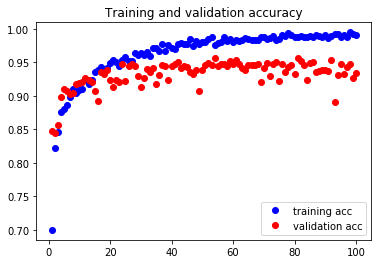

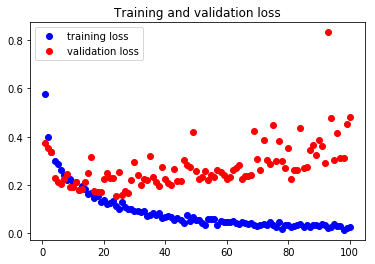

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'ro', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'ro', label='validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [26]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.5539577577574164
Validation accuracy: 0.928999993801117
